<a href="https://www.kaggle.com/code/kurezu/booking-kurezu?scriptVersionId=122321913" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
display(f'Количество дублей в тренировочном сете: {df_train[df_train.duplicated()].shape[0]}')

'Количество дублей в тренировочном сете: 307'

In [8]:
# удалим дубли в тренировочном сете
df_train = df_train.drop_duplicates()

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [10]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [11]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [13]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [15]:
data.nunique()
data.corr()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
additional_number_of_scoring,1.000000,-0.153012,0.029193,0.824904,-0.053133,-0.071971,0.336281,-0.295817,0.000793,-0.018714
average_score,-0.153012,1.000000,-0.112347,-0.179554,0.106723,0.036529,-0.108721,0.106093,-0.000659,0.113686
review_total_negative_word_counts,0.029193,-0.112347,1.000000,0.035110,0.119664,0.003234,0.019120,-0.020006,-0.000021,-0.120581
total_number_of_reviews,0.824904,-0.179554,0.035110,1.000000,-0.030146,-0.024918,0.100284,-0.014182,0.000314,-0.022768
review_total_positive_word_counts,-0.053133,0.106723,0.119664,-0.030146,1.000000,0.026534,-0.037585,0.035482,0.000065,0.069021
total_number_of_reviews_reviewer_has_given,-0.071971,0.036529,0.003234,-0.024918,0.026534,1.000000,-0.059804,0.110848,0.001725,0.002396
lat,0.336281,-0.108721,0.019120,0.100284,-0.037585,-0.059804,1.000000,-0.304539,0.000599,-0.011091
lng,-0.295817,0.106093,-0.020006,-0.014182,0.035482,0.110848,-0.304539,1.000000,-0.000120,0.010831
sample,0.000793,-0.000659,-0.000021,0.000314,0.000065,0.001725,0.000599,-0.000120,1.000000,0.931821
reviewer_score,-0.018714,0.113686,-0.120581,-0.022768,0.069021,0.002396,-0.011091,0.010831,0.931821,1.000000


___


In [16]:
# некрасивое заполнение координат, не будем так делать
# data['lat'] = data['lat'].fillna(0)
# data['lng'] = data['lng'].fillna(0)

In [17]:
# попробуем извлечь из адреса странц и город
data['country'] = data['hotel_address'].apply(lambda x: x.split(' ')[-1])
data['city'] = data['hotel_address'].apply(lambda x: x.split(' ')[-2])
display(set(data['country'].to_list()))
display(set(data['city'].to_list()))
# по выводу видно, что проблема только с United Kingdom. Сделаем отдельные функции

{'Austria', 'France', 'Italy', 'Kingdom', 'Netherlands', 'Spain'}

{'Amsterdam', 'Barcelona', 'Milan', 'Paris', 'United', 'Vienna'}

In [18]:
def adress_country(adr):
    x = adr.split(' ')[-1]
    if x == 'Kingdom':
        country = adr.split(' ')[-2]+' '+adr.split(' ')[-1]
    else:
        country = adr.split(' ')[-1]
    return country

def adress_city(adr):
    x = adr.split(' ')[-1]
    if x == 'Kingdom':
        city = adr.split(' ')[-5]
    else:
        city = adr.split(' ')[-2]
    return city

data['country'] = data['hotel_address'].apply(adress_country)
data['city'] = data['hotel_address'].apply(adress_city)
display(set(data['country'].to_list()))
display(set(data['city'].to_list()))
# зная город мы можем заполнить координаты (пусть и не точные координаты отеля, но и не случайные)

{'Austria', 'France', 'Italy', 'Netherlands', 'Spain', 'United Kingdom'}

{'Amsterdam', 'Barcelona', 'London', 'Milan', 'Paris', 'Vienna'}

In [19]:
display(set(data[data['lat'].isna()]['city'].to_list()))
#{'Barcelona', 'Paris', 'Vienna'} у нас всего 3 города, к которым нужны будут координаты. В таком случае проще нагуглить и добавить координаты трёх городов руками, чем изобретать код с авто-поиском координат.

city_coord = {'Barcelona': [41.390205, 2.154007], 'Paris': [48.864716, 2.349014], 'Vienna': [48.210033, 16.363449]}

# заполним перебором строк с пустыми значениями в координатах
index_na = data[data['lat'].isna()].index.to_list()
for ind in index_na:
    data.loc[ind, 'lat'] = city_coord[data.loc[ind, 'city']][0]
    data.loc[ind, 'lng'] = city_coord[data.loc[ind, 'city']][1]
    
display(data.info())

{'Barcelona', 'Paris', 'Vienna'}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

None

In [20]:
# закодируем города и удалим столбцы с адресом, городом и страной
city_one_hot = pd.get_dummies(data['city'])
data = pd.concat([data, city_one_hot], axis=1)
data = data.drop(columns=['hotel_address', 'country', 'city']) 

In [21]:
# преобразуем дату обзора в месяц и выделим сезон, думаю сезон имеет значение
data['review_date'] = pd.to_datetime(data['review_date']).dt.month

def season(x):
    if x == 12 or x<3:
        return 'winter'
    elif x >= 3 and x < 6:
        return 'spring'
    elif x >= 6 and x < 9:
        return 'summer'
    elif x >= 9 and x < 12:
        return 'autumn'

data['season'] = data['review_date'].apply(season)

# закодируем сезон
season_one_hot = pd.get_dummies(data['season'])
data = pd.concat([data, season_one_hot], axis=1)
data = data.drop(columns=['review_date', 'season']) 
data

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,Amsterdam,Barcelona,London,Milan,Paris,Vienna,autumn,spring,summer,winter
0,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,...,0,0,0,1,0,0,0,0,1,0
1,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,...,1,0,0,0,0,0,0,0,0,1
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,...,0,1,0,0,0,0,1,0,0,0
3,241,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,...,0,0,0,1,0,0,1,0,0,0
4,834,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515426,107,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,...,0,0,1,0,0,0,0,1,0,0
515427,272,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,...,0,0,0,0,0,1,0,0,0,1
515428,457,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,...,0,0,1,0,0,0,0,0,0,1
515429,365,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,...,0,0,1,0,0,0,0,1,0,0


In [22]:
a = list(set(data[data['review_total_positive_word_counts']==0]['positive_review'].to_list()))
print(set(a))
a = list(set(data[data['review_total_negative_word_counts']==0]['negative_review'].to_list()))
print(set(a))

{'No Positive'}
{'No Negative'}


In [23]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# первым делом подправим явные выражения 
data['negative_review'] = data['negative_review'].apply(lambda x: x.lower().replace('no negative', 'Positive'))
data['positive_review'] = data['positive_review'].apply(lambda x: x.lower().replace('no positive', 'Negative'))

sia_neg = SentimentIntensityAnalyzer()
sia_pos = SentimentIntensityAnalyzer()

data['neg_scores'] = data['negative_review'].apply(lambda x: sia_neg.polarity_scores(x))
data['pos_scores'] = data['positive_review'].apply(lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
data['n_neg'] = data['neg_scores'].apply(lambda x: x['neg'])
data['n_neu'] = data['neg_scores'].apply(lambda x: x['neu'])
data['n_pos'] = data['neg_scores'].apply(lambda x: x['pos'])
data['n_compound'] = data['neg_scores'].apply(lambda x: x['compound'])

data['p_neg'] = data['pos_scores'].apply(lambda x: x['neg'])
data['p_neu'] = data['pos_scores'].apply(lambda x: x['neu'])
data['p_pos'] = data['pos_scores'].apply(lambda x: x['pos'])
data['p_compound'] = data['pos_scores'].apply(lambda x: x['compound'])

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [24]:
col_name= data[['average_score',
                'review_total_negative_word_counts',
                'review_total_positive_word_counts',
                'total_number_of_reviews_reviewer_has_given',
                'total_number_of_reviews'
               ]]

scaler = preprocessing.StandardScaler()
data_scalar = scaler.fit_transform(col_name)
data_scalar = pd.DataFrame(data_scalar,columns=col_name.columns)

data_scalar.sample(3)

#заменяем признаки на скалированные в исходном датасете.
data = data.drop(col_name,axis =1) 
data = pd.concat([data,data_scalar],axis =1).reset_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 37 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   index                                       515431 non-null  int64  
 1   additional_number_of_scoring                515431 non-null  int64  
 2   hotel_name                                  515431 non-null  object 
 3   reviewer_nationality                        515431 non-null  object 
 4   negative_review                             515431 non-null  object 
 5   positive_review                             515431 non-null  object 
 6   tags                                        515431 non-null  object 
 7   days_since_review                           515431 non-null  object 
 8   lat                                         515431 non-null  float64
 9   lng                                         515431 non-null  float64
 

<AxesSubplot:>

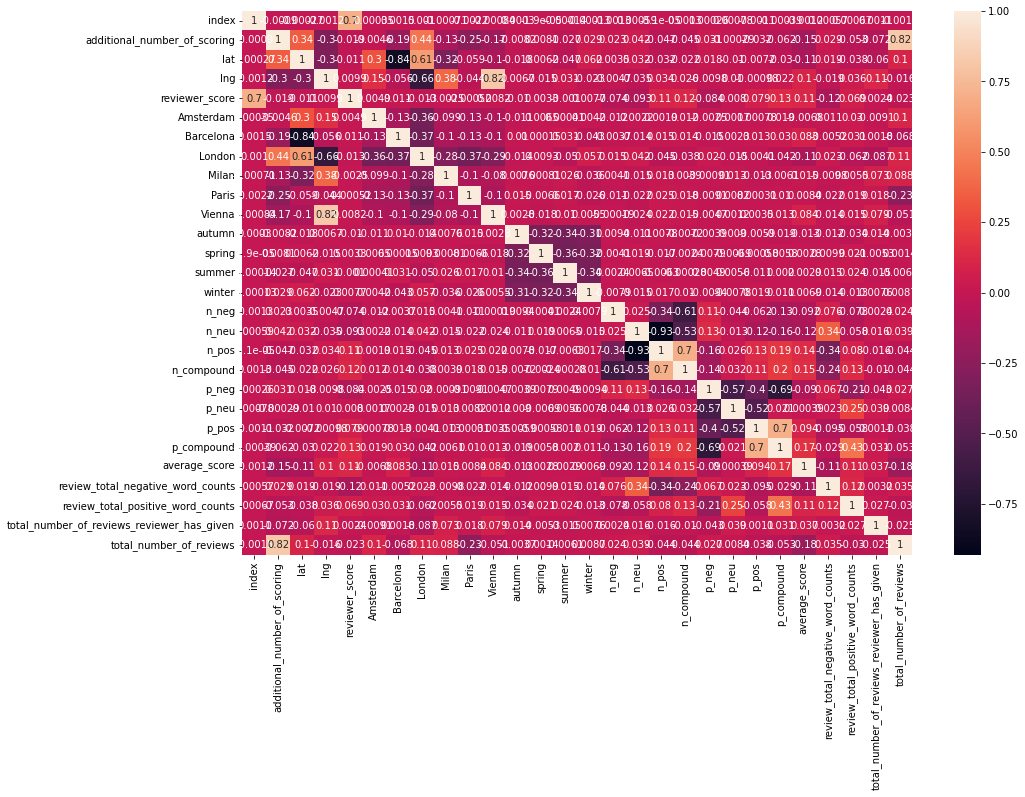

In [25]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [26]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   index                                       515431 non-null  int64  
 1   additional_number_of_scoring                515431 non-null  int64  
 2   lat                                         515431 non-null  float64
 3   lng                                         515431 non-null  float64
 4   sample                                      515431 non-null  int64  
 5   reviewer_score                              515431 non-null  float64
 6   Amsterdam                                   515431 non-null  uint8  
 7   Barcelona                                   515431 non-null  uint8  
 8   London                                      515431 non-null  uint8  
 9   Milan                                       515431 non-null  uint8  
 

In [28]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [29]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [30]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 28), (386496, 28), (386496, 27), (309196, 27), (77300, 27))

In [31]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [32]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [33]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


In [34]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8819772703751614


<AxesSubplot:>

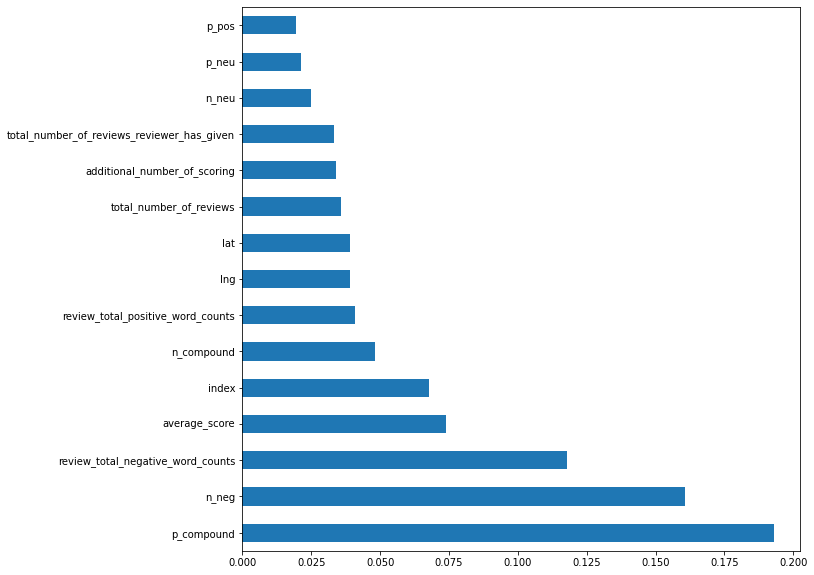

In [35]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [36]:
test_data.sample(10)

,index,additional_number_of_scoring,lat,lng,reviewer_score,Amsterdam,Barcelona,London,Milan,Paris,...,n_compound,p_neg,p_neu,p_pos,p_compound,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,total_number_of_reviews
78076,78076,1274,51.510995,-0.186342,0.0,0,0,1,0,0,...,-0.0258,0.0,0.690,0.310,0.4019,-1.272971,0.116542,-0.448436,-0.558508,1.637202
98824,98824,137,51.492235,-0.191423,0.0,0,0,1,0,0,...,0.4560,0.0,0.896,0.104,0.4404,0.369267,1.194312,0.560591,-0.105557,-0.675315
54036,54036,930,51.507271,-0.021121,0.0,0,0,1,0,0,...,-0.1027,0.0,0.606,0.394,0.5994,0.916680,0.015501,-0.448436,-0.558508,0.039581
112018,112018,77,48.873514,2.321746,0.0,0,0,0,0,1,...,-0.1531,0.0,0.690,0.310,0.8399,1.099150,1.531115,0.285401,-0.558508,-0.831496
44490,44490,203,48.870960,2.309162,0.0,0,0,0,0,1,...,0.0000,0.0,1.000,0.000,0.0000,-0.543087,-0.557064,-0.677761,0.075623,-0.552786
90645,90645,440,52.375493,4.892988,0.0,1,0,0,0,0,...,0.0000,0.0,1.000,0.000,0.0000,0.916680,-0.557064,-0.723626,-0.105557,-0.073457
121920,121920,100,48.884858,2.299702,0.0,0,0,0,0,1,...,0.5574,0.0,0.424,0.576,0.7778,0.734209,-0.624425,-0.402572,-0.558508,-0.753405
12910,12910,237,41.393599,2.168415,0.0,0,1,0,0,0,...,0.5574,1.0,0.000,0.000,-0.5719,-0.178145,-0.624425,-0.815355,-0.558508,-0.160607
60026,60026,538,52.376046,4.894392,0.0,1,0,0,0,0,...,-0.3626,1.0,0.000,0.000,-0.5719,-0.360616,-0.119220,-0.815355,0.256804,0.257889
59255,59255,143,41.393863,2.156804,0.0,0,1,0,0,0,...,0.0000,0.0,0.319,0.681,0.8923,-0.543087,-0.557064,-0.402572,-0.558508,-0.356481


In [37]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [38]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [39]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


In [40]:
predict_submission

array([8.648, 7.3  , 8.284, ..., 8.166, 9.19 , 6.879])

In [41]:
list(sample_submission)

['reviewer_score', 'id']

In [42]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.648,488440
1,7.300,274649
2,8.284,374688
3,9.420,404352
4,9.271,451596
5,9.138,302161
6,7.069,317079
7,7.849,13963
8,8.653,159785
9,7.886,195089
